In [49]:
from scipy.special import softmax
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from nltk.sentiment import SentimentIntensityAnalyzer

In [30]:
sia = SentimentIntensityAnalyzer()

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [31]:
df = pd.read_csv("data/01_raw/Reviews.csv")

In [32]:
df = df.head(500)

In [33]:
example = df["Text"][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [34]:
encoded = tokenizer(example, return_tensors="pt")
output = model(**encoded)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    "negative": scores[0], 
    "neutral": scores[1], 
    "positive": scores[2]
}
print(scores_dict)

{'negative': 0.97635514, 'neutral': 0.020687466, 'positive': 0.002957372}


In [38]:
def polarity_scores(text) -> dict:
    encoded = tokenizer(text, return_tensors="pt")
    output = model(**encoded)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg": scores[0], 
        "roberta_neu": scores[1], 
        "roberta_pos": scores[2]
    }
    return scores_dict

In [44]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["Text"]
        myid = row["Id"]

        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        both = {
            **vader_result_rename,
            **roberta_result
        }
        res[myid] = both
    except Exception as e:
        print(f"Failed for row {myid} beacause: {e}")

  0%|          | 0/500 [00:00<?, ?it/s]

Failed for row 83 beacause: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]
Failed for row 187 beacause: The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]


In [46]:
res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename(columns={"index": "Id"})
res_df = res_df.merge(df, how="left")

In [48]:
# res_df.head()

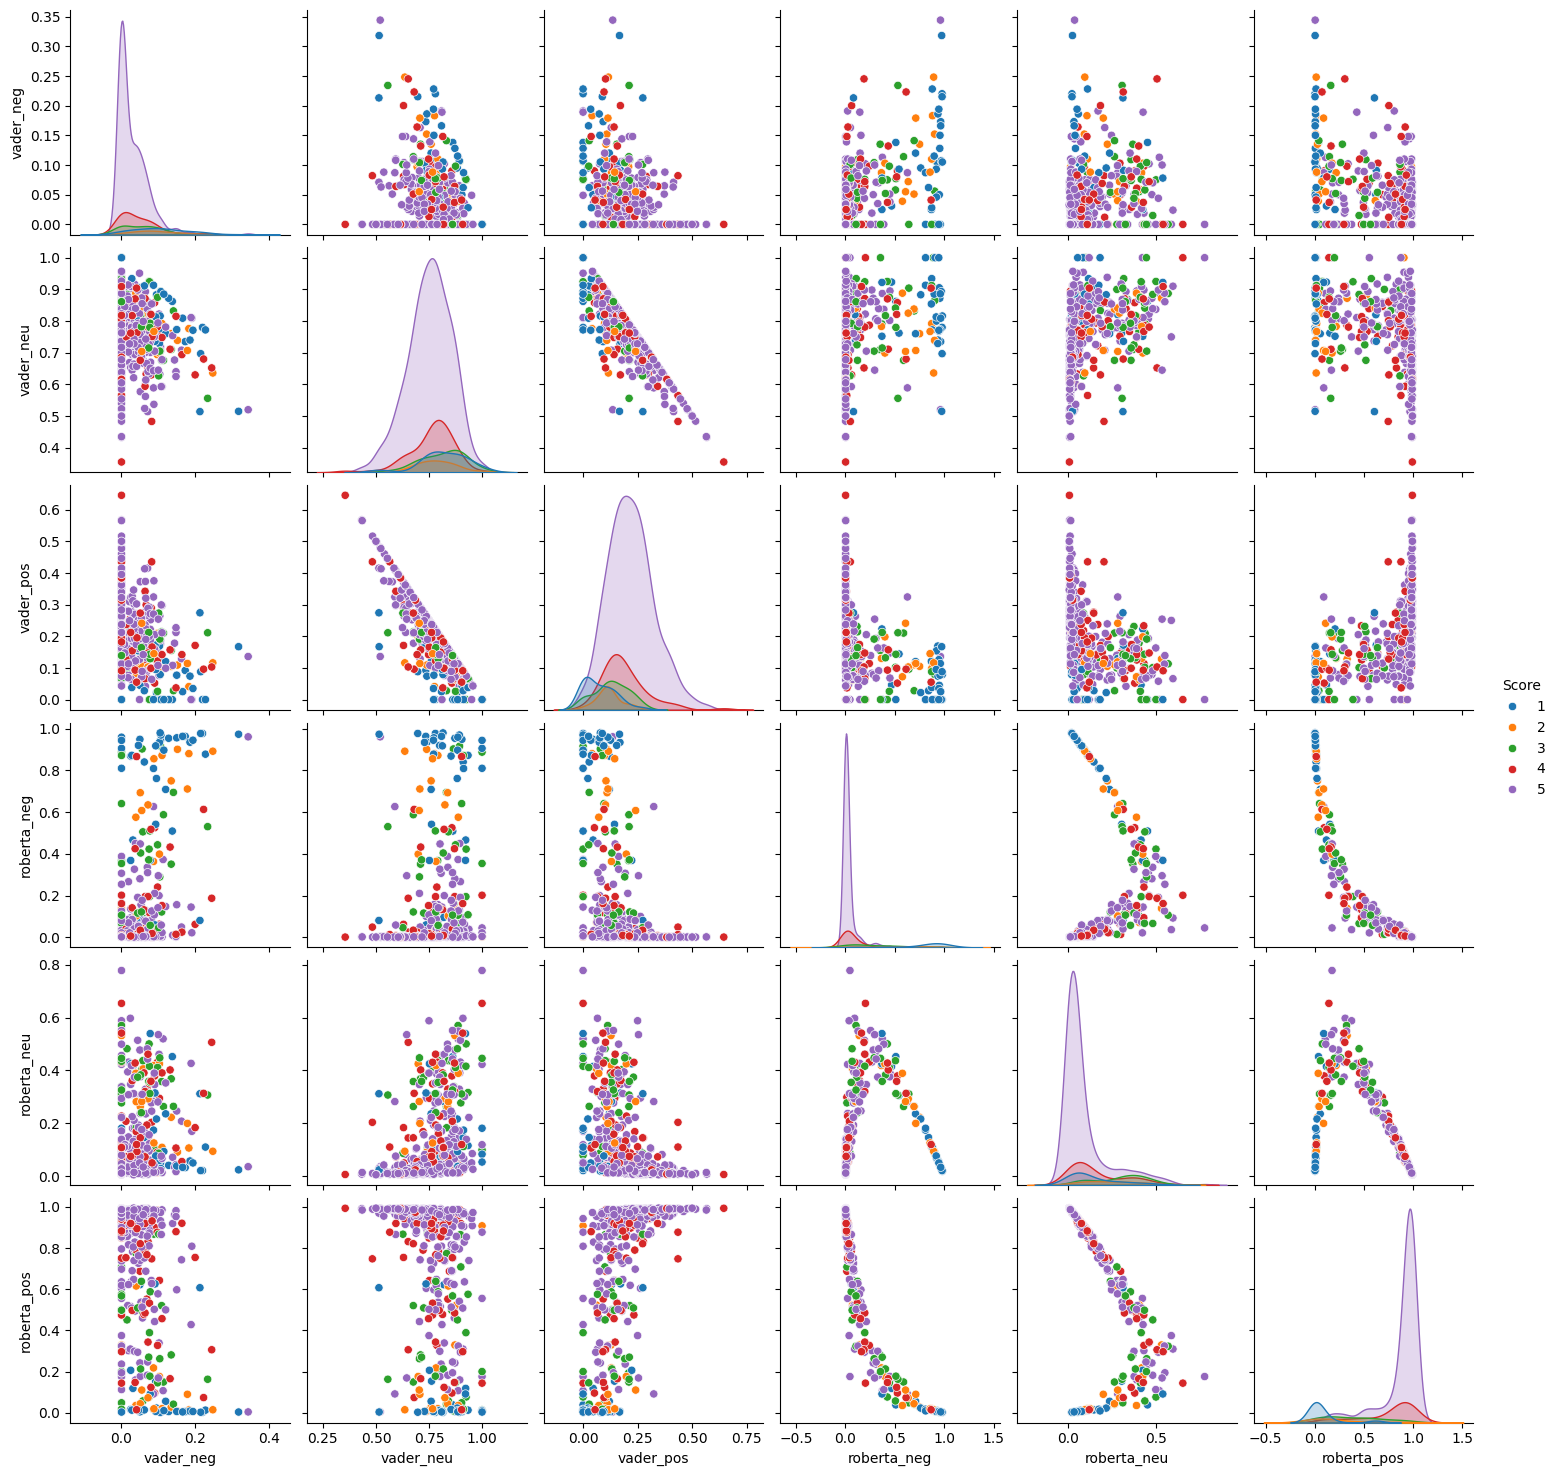

In [51]:
sns.pairplot(res_df,
             vars=["vader_neg", "vader_neu", "vader_pos", 
                  "roberta_neg", "roberta_neu", "roberta_pos"], 
             hue="Score",
             palette='tab10',)
plt.show()

In [59]:
print(
    res_df.query("Score == 1").
    sort_values("roberta_pos", ascending=False)['Text'].values[0]
    )
res_df.query("Score == 1") \
    .sort_values("roberta_pos", ascending=False)["roberta_pos"].values[0]


I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.


0.6256365776062012

In [61]:
print(res_df.query("Score == 1")
      .sort_values("vader_pos", ascending=False)['Text'].values[0])
res_df.query("Score == 1") \
    .sort_values("vader_pos", ascending=False)["vader_pos"].values[0]

So we cancelled the order.  It was cancelled without any problem.  That is a positive note...


0.274

In [62]:
print(
    res_df.query("Score == 5").
    sort_values("roberta_neg", ascending=False)['Text'].values[0]
    )
res_df.query("Score == 5") \
    .sort_values("roberta_neg", ascending=False)["roberta_neg"].values[0]

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


0.9601579308509827

In [63]:
print(res_df.query("Score == 5")
      .sort_values("vader_neg", ascending=False)['Text'].values[0])
res_df.query("Score == 5") \
    .sort_values("vader_neg", ascending=False)["vader_neg"].values[0]

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


0.344